In [140]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers, _butter_lowpass
from lib.analysis import _get_gait_events_from_OMC
import os
from scipy.signal import find_peaks

In [63]:
# Set data directory
PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"

# Get a list of participant ids
participant_ids = [folder_name for folder_name in os.listdir(PARENT_FOLDER) if folder_name.startswith("pp")]
print(f"Number of participants: {len(participant_ids)}")

Number of participants: 120


In [185]:
# Trial to investigate
trial_name = "walk_preferred"

# Loop over the participants
for (ix_participant, participant_id) in enumerate(participant_ids[8:9]):

    # Get a list of OMC data files
    omc_filenames = [file_name for file_name in os.listdir(os.path.join(PARENT_FOLDER, participant_id, "optical")) if file_name.endswith(".mat")]

    # Select only the file corresponding to the trial of interest
    ix_omc_filename = [ix for ix in range(len(omc_filenames)) if ("walk_preferred" in omc_filenames[ix])]
    if len(ix_omc_filename) > 0:
        ix_omc_filename = ix_omc_filename[0]
        omc_filename = omc_filenames[ix_omc_filename]

        # Check if there is an equivalent IMU file
        if os.path.isfile(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_filename.replace("omc_", "imu_"))):
            imu_filename = omc_filename.replace("omc_", "imu_")

            # Load the data
            omc_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "optical", omc_filename))
            imu_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "imu", imu_filename))
print(f"Participant: {participant_id}")

Participant: pp009


In [186]:
# Get sampling frequency
fs = omc_data["fs"]
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 200 Hz


In [187]:
M = omc_data["pos"][:,:3,:]  # get marker position data
n_time_steps, n_dimensions, n_markers = M.shape
M = np.reshape(M, (n_time_steps, 3*n_markers), order="F")
M = _predict_missing_markers(M)

In [188]:
M = _butter_lowpass(M, fs)
M = np.reshape(M, (n_time_steps, n_dimensions, n_markers), order="F")

In [189]:
# Copy array
data = M.copy()
labels = omc_data["marker_location"]

# Get position data for relevant markers
l_heel_pos = np.squeeze(data[:,:,np.argwhere(labels=='l_heel')[:,0]], axis=-1)
r_heel_pos = np.squeeze(data[:,:,np.argwhere(labels=='r_heel')[:,0]], axis=-1)
l_toe_pos = np.squeeze(data[:,:,np.argwhere(labels=='l_toe')[:,0]], axis=-1)
r_toe_pos = np.squeeze(data[:,:,np.argwhere(labels=='r_toe')[:,0]], axis=-1)
l_psis_pos = np.squeeze(data[:,:,np.argwhere(labels=='l_psis')[:,0]], axis=-1)
r_psis_pos = np.squeeze(data[:,:,np.argwhere(labels=='r_psis')[:,0]], axis=-1)
l_asis_pos = np.squeeze(data[:,:,np.argwhere(labels=='l_asis')[:,0]], axis=-1)
r_asis_pos = np.squeeze(data[:,:,np.argwhere(labels=='r_asis')[:,0]], axis=-1)

# Get position data for auxiliary markers
start_1 = np.squeeze(data[:,:,np.argwhere(labels=='start_1')[:,0]], axis=-1)
start_2 = np.squeeze(data[:,:,np.argwhere(labels=='start_2')[:,0]], axis=-1)
end_1 = np.squeeze(data[:,:,np.argwhere(labels=='end_1')[:,0]], axis=-1)
end_2 = np.squeeze(data[:,:,np.argwhere(labels=='end_2')[:,0]], axis=-1)

In [190]:
# Compute virtual markers
mid_asis = ( l_asis_pos + r_asis_pos ) / 2
mid_psis = ( l_psis_pos + r_psis_pos ) / 2
mid_spine = ( mid_asis + mid_psis ) / 2
mid_start = ( start_1 + start_2 ) / 2
mid_end = ( end_1 + end_2 ) / 2
l_mid_foot_pos = ( l_heel_pos + l_toe_pos ) / 2
r_mid_foot_pos = ( r_heel_pos + r_toe_pos ) / 2

In [191]:
# Determine beginning and ending of trial
distances = np.sqrt(np.sum(((mid_spine - mid_start)**2)[:,:2], axis=1))
ix_start = np.argmin(distances)

distances = np.sqrt(np.sum(((mid_spine - mid_end)**2)[:,:2], axis=1))
ix_end = np.argmin(distances)

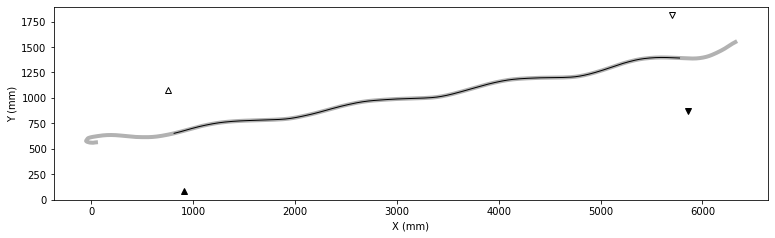

In [192]:
# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12.8, 4.8))
ax.plot(np.mean(start_1[:,0]), np.mean(start_1[:,1]), '^', mfc='none', mec='k')
ax.plot(np.mean(start_2[:,0]), np.mean(start_2[:,1]), '^', mfc='k', mec='k')
ax.plot(np.mean(end_1[:,0]), np.mean(end_1[:,1]), 'v', mfc='none', mec='k')
ax.plot(np.mean(end_2[:,0]), np.mean(end_2[:,1]), 'v', mfc='k', mec='k')
ax.plot(mid_spine[:,0], mid_spine[:,1], '-', c=(0, 0, 0, 0.3), lw=4)
ax.plot(mid_spine[ix_start:ix_end,0], mid_spine[ix_start:ix_end,1], '-', c=(0, 0, 0, 1), lw=1)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_aspect('equal')
plt.show()

In [193]:
# Determine the direction of motion - this defines the local antero-posterior axis
e_x = np.zeros_like(mid_spine)
e_x[1:,:] = mid_spine[1:,:] - mid_spine[:-1,:]
e_x[0,:] = e_x[1,:]
e_x = np.divide(e_x, np.expand_dims(np.linalg.norm(e_x, axis=1)+np.finfo(float).eps, axis=-1))

# Setup the local vertical axis
e_z = np.zeros_like(e_x)
e_z[:,2] = 1

# Estimate the local medio-lateral axis
e_y = np.cross(e_z, e_x)
e_y = np.divide(e_y, np.expand_dims(np.linalg.norm(e_y, axis=1)+np.finfo(float).eps, axis=-1))

# Final estimate of antero-posterior axis
e_x = np.cross(e_y, e_z)

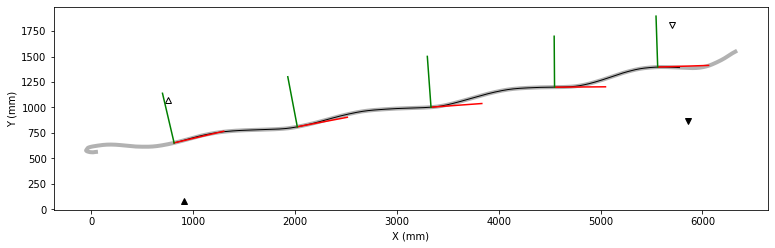

In [194]:
# Visualize
K = 500  # scale factor for visualizing unit vectors
fig, ax = plt.subplots(1, 1, figsize=(12.8, 4.8))
ax.plot(np.mean(start_1[:,0]), np.mean(start_1[:,1]), '^', mfc='none', mec='k')
ax.plot(np.mean(start_2[:,0]), np.mean(start_2[:,1]), '^', mfc='k', mec='k')
ax.plot(np.mean(end_1[:,0]), np.mean(end_1[:,1]), 'v', mfc='none', mec='k')
ax.plot(np.mean(end_2[:,0]), np.mean(end_2[:,1]), 'v', mfc='k', mec='k')
ax.plot(mid_spine[:,0], mid_spine[:,1], '-', c=(0, 0, 0, 0.3), lw=4)
ax.plot(mid_spine[ix_start:ix_end,0], mid_spine[ix_start:ix_end,1], '-', c=(0, 0, 0, 1), lw=1)
for t in range(ix_start, ix_end, fs):
    ax.plot([mid_spine[t,0], mid_spine[t,0]+K*e_x[t,0]], [mid_spine[t,1], mid_spine[t,1]+K*e_x[t,1]], 'r-')
    ax.plot([mid_spine[t,0], mid_spine[t,0]+K*e_y[t,0]], [mid_spine[t,1], mid_spine[t,1]+K*e_y[t,1]], 'g-')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_aspect('equal')
plt.show()
del K

In [195]:
# Take the average over the trial
e_h_x = np.mean(e_x[ix_start:ix_end,:], axis=0)
e_h_y = np.mean(e_y[ix_start:ix_end,:], axis=0)
e_h_z = np.mean(e_z[ix_start:ix_end,:], axis=0)
R = np.array([e_h_x, e_h_y, e_h_z])

### **Automatic Detection of Gait Events Using Kinematic Data**, O'Connor *et al*., 2007

- A new signal, representing the foot centre, is created by calculating the midpoint of the heel and toe marker locations.
- The vertical velocity of the foot centre is calculated by taking the first derivative of the vertical coordinates using finite difference equations.

In [196]:
# Calculate the velocity signals
l_mid_foot_vel = np.zeros_like(l_mid_foot_pos)
l_mid_foot_vel[1:,:] = ( l_mid_foot_pos[1:,:] - l_mid_foot_pos[:-1,:] ) / (1/fs)
l_mid_foot_vel[0,:] = l_mid_foot_vel[1,:]
r_mid_foot_vel = np.zeros_like(r_mid_foot_pos)
r_mid_foot_vel[1:,:] = ( r_mid_foot_pos[1:,:] - r_mid_foot_pos[:-1,:] ) / (1/fs)
r_mid_foot_vel[0,:] = r_mid_foot_vel[1,:]

In [197]:
# Calculate distance from mid foot to start point
dl_mid_foot_pos = np.sqrt(np.sum(((l_mid_foot_pos - mid_start)**2)[:,:2], axis=1))
dr_mid_foot_pos = np.sqrt(np.sum(((r_mid_foot_pos - mid_start)**2)[:,:2], axis=1))

# Calculate velocity signals
dl_mid_foot_vel = np.zeros_like(dl_mid_foot_pos)
dl_mid_foot_vel[1:] = (dl_mid_foot_pos[1:] - dl_mid_foot_pos[:-1]) / (1/fs)
dl_mid_foot_vel[0] = dl_mid_foot_vel[1]
dr_mid_foot_vel = np.zeros_like(dr_mid_foot_pos)
dr_mid_foot_vel[1:] = (dr_mid_foot_pos[1:] - dr_mid_foot_pos[:-1]) / (1/fs)
dr_mid_foot_vel[0] = dr_mid_foot_vel[1]

In [198]:
# Find local maxima in the forward velocity -- foot moves forward
thr_min_distance = fs // 4
thr_min_height = 0.1 * ( np.max(dl_mid_foot_vel[ix_start:ix_end]) - np.min(dl_mid_foot_vel[ix_start:ix_end]) )
l_ix_max_vel_x, _ = find_peaks(dl_mid_foot_vel, height=thr_min_height, distance=thr_min_distance)

thr_min_height = 0.1 * ( np.max(dr_mid_foot_vel[ix_start:ix_end]) - np.min(dr_mid_foot_vel[ix_start:ix_end]) )
r_ix_max_vel_x, _ = find_peaks(dr_mid_foot_vel, height=thr_min_height, distance=thr_min_distance)

In [199]:
# Find local minima in the vertical velocity -- foot moves downward
thr_min_distance = fs // 20
thr_min_height = 0.1 * ( np.max(l_mid_foot_vel[ix_start:ix_end,2]) - np.min(l_mid_foot_vel[ix_start:ix_end,2]) )
l_ix_min_vel_z, _ = find_peaks(-l_mid_foot_vel[:,2], height=thr_min_height, distance=thr_min_distance)

thr_min_height = 0.1 * ( np.max(r_mid_foot_vel[ix_start:ix_end,2]) - np.min(r_mid_foot_vel[ix_start:ix_end,2]) )
r_ix_min_vel_z, _ = find_peaks(-r_mid_foot_vel[:,2], height=thr_min_height, distance=thr_min_distance)

In [200]:
# Find local maxima in the vertical velocity -- foot moves up
thr_min_distance = fs // 20
thr_min_height = 0.1 * ( np.max(l_mid_foot_vel[ix_start:ix_end,2]) - np.min(l_mid_foot_vel[ix_start:ix_end,2]) )
l_ix_max_vel_z, _ = find_peaks(l_mid_foot_vel[:,2], height=thr_min_height, distance=thr_min_distance)

thr_min_height = 0.1 * ( np.max(r_mid_foot_vel[ix_start:ix_end,2]) - np.min(r_mid_foot_vel[ix_start:ix_end,2]) )
r_ix_max_vel_z, _ = find_peaks(r_mid_foot_vel[:,2], height=thr_min_height, distance=thr_min_distance)

In [207]:
l_ix_IC, l_ix_FC = [], []
for i in l_ix_max_vel_x:
    f = np.argwhere(np.logical_and(l_ix_min_vel_z > i, l_ix_min_vel_z < i+(fs//4)))[:,0]
    if len(f) > 0:
        l_ix_IC.append(l_ix_min_vel_z[f[0]])
    f = np.argwhere(l_ix_max_vel_z < i)[:,0]
    if len(f) > 0:
        l_ix_FC.append(l_ix_max_vel_z[f[-1]])
l_ix_IC, l_ix_FC = np.array(l_ix_IC), np.array(l_ix_FC)

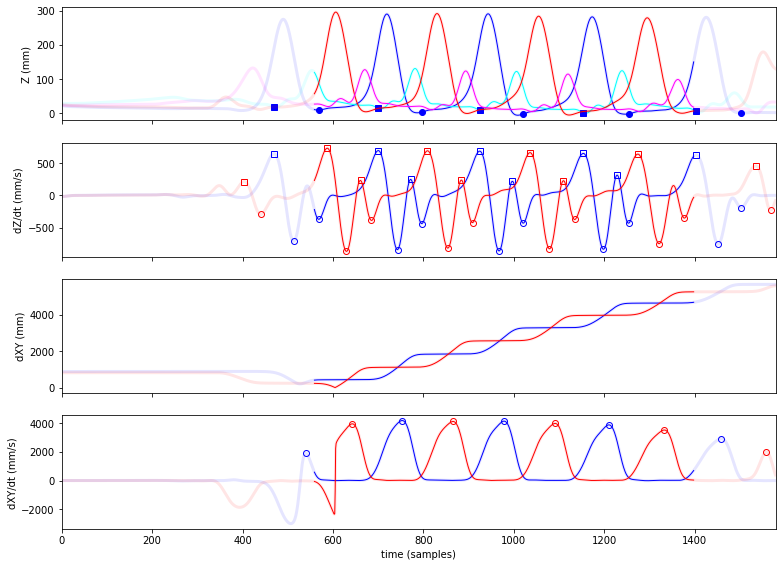

In [213]:
# Visualize
fig, axs = plt.subplots(4, 1, figsize=(12.8, 9.6), sharex=True)
axs[0].plot(np.arange(l_heel_pos.shape[0]), l_heel_pos[:,2], '-', c=(0, 0, 1, 0.1), lw=3)
axs[0].plot(np.arange(ix_start, ix_end), l_heel_pos[ix_start:ix_end,2], '-', c=(0, 0, 1, 1), lw=1)
axs[0].plot(l_ix_IC, l_heel_pos[l_ix_IC,2], 'o', mec='b', mfc='b')

axs[0].plot(np.arange(l_toe_pos.shape[0]), l_toe_pos[:,2], '-', c=(0, 1, 1, 0.1), lw=3)
axs[0].plot(np.arange(ix_start, ix_end), l_toe_pos[ix_start:ix_end,2], '-', c=(0, 1, 1, 1), lw=1)
axs[0].plot(l_ix_FC, l_toe_pos[l_ix_FC,2], 's', mec=(0, 0, 1, 1), mfc=(0, 0, 1, 1))

axs[0].plot(np.arange(r_heel_pos.shape[0]), r_heel_pos[:,2], '-', c=(1, 0, 0, 0.1), lw=3)
axs[0].plot(np.arange(ix_start, ix_end), r_heel_pos[ix_start:ix_end,2], '-', c=(1, 0, 0, 1), lw=1)

axs[0].plot(np.arange(r_toe_pos.shape[0]), r_toe_pos[:,2], '-', c=(1, 0, 1, 0.1), lw=3)
axs[0].plot(np.arange(ix_start, ix_end), r_toe_pos[ix_start:ix_end,2], '-', c=(1, 0, 1, 1), lw=1)

axs[0].set_ylabel('Z (mm)')

axs[1].plot(np.arange(l_mid_foot_vel.shape[0]), l_mid_foot_vel[:,2], '-', c=(0, 0, 1, 0.1), lw=3)
axs[1].plot(np.arange(ix_start, ix_end), l_mid_foot_vel[ix_start:ix_end,2], '-', c=(0, 0, 1, 1), lw=1)
axs[1].plot(l_ix_min_vel_z, l_mid_foot_vel[l_ix_min_vel_z,2], 'o', mfc='none', mec=(0, 0, 1, 1), lw=1)
axs[1].plot(l_ix_max_vel_z, l_mid_foot_vel[l_ix_max_vel_z,2], 's', mfc='none', mec=(0, 0, 1, 1), lw=1)
axs[1].plot(np.arange(r_mid_foot_vel.shape[0]), r_mid_foot_vel[:,2], '-', c=(1, 0, 0, 0.1), lw=3)
axs[1].plot(np.arange(ix_start, ix_end), r_mid_foot_vel[ix_start:ix_end,2], '-', c=(1, 0, 0, 1), lw=1)
axs[1].plot(r_ix_min_vel_z, r_mid_foot_vel[r_ix_min_vel_z,2], 'o', mfc='none', mec=(1, 0, 0, 1), lw=1)
axs[1].plot(r_ix_max_vel_z, r_mid_foot_vel[r_ix_max_vel_z,2], 's', mfc='none', mec=(1, 0, 0, 1), lw=1)
axs[1].set_ylabel('dZ/dt (mm/s)')
axs[2].plot(np.arange(dl_mid_foot_pos.shape[0]), dl_mid_foot_pos, '-', c=(0, 0, 1, 0.1), lw=3)
axs[2].plot(np.arange(ix_start, ix_end), dl_mid_foot_pos[ix_start:ix_end], '-', c=(0, 0, 1, 1), lw=1)
axs[2].plot(np.arange(dr_mid_foot_pos.shape[0]), dr_mid_foot_pos, '-', c=(1, 0, 0, 0.1), lw=3)
axs[2].plot(np.arange(ix_start, ix_end), dr_mid_foot_pos[ix_start:ix_end], '-', c=(1, 0, 0, 1), lw=1)
axs[2].set_ylabel('dXY (mm)')
axs[3].plot(np.arange(dl_mid_foot_vel.shape[0]), dl_mid_foot_vel, '-', c=(0, 0, 1, 0.1), lw=3)
axs[3].plot(np.arange(ix_start, ix_end), dl_mid_foot_vel[ix_start:ix_end], '-', c=(0, 0, 1, 1), lw=1)
axs[3].plot(l_ix_max_vel_x, dl_mid_foot_vel[l_ix_max_vel_x], 'o', mfc='none', mec=(0, 0, 1, 1), lw=1)
axs[3].plot(np.arange(dr_mid_foot_vel.shape[0]), dr_mid_foot_vel, '-', c=(1, 0, 0, 0.1), lw=3)
axs[3].plot(np.arange(ix_start, ix_end), dr_mid_foot_vel[ix_start:ix_end], '-', c=(1, 0, 0, 1), lw=1)
axs[3].plot(r_ix_max_vel_x, dr_mid_foot_vel[r_ix_max_vel_x], 'o', mfc='none', mec=(1, 0, 0, 1), lw=1)
axs[3].set_ylabel('dXY/dt (mm/s)')
axs[3].set_xlabel('time (samples)')
axs[3].set_xlim(0, l_heel_pos.shape[0])
plt.show()